Product line,somme
Home and lifestyle,2564.8530000000005
Fashion accessories,2585.9950000000003
Health and beauty,2342.559
Electronic access...,2587.5015000000003
Food and beverages,2673.564
Sports and travel,2624.8965


<Figure size 864x504 with 0 Axes>

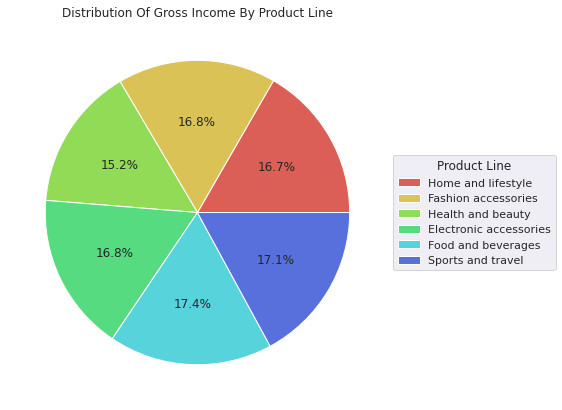

Product line,nrbSales
Home and lifestyle,160
Fashion accessories,178
Health and beauty,152
Electronic access...,170
Food and beverages,174
Sports and travel,166


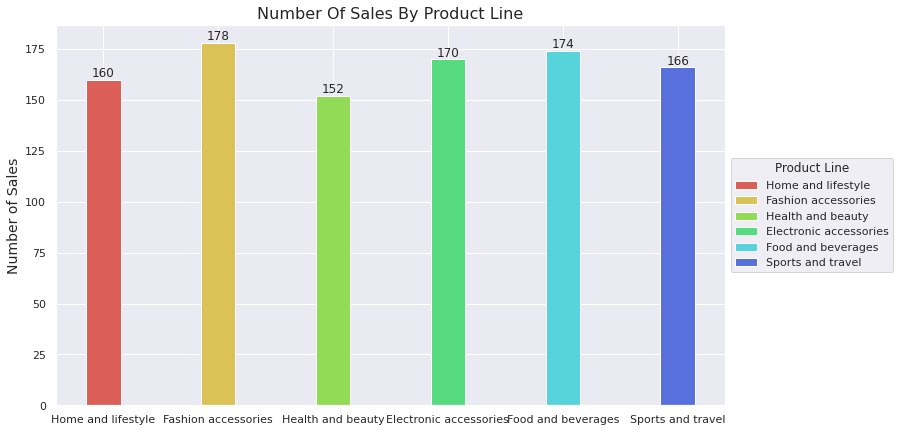

Product line,Gender,Quantity
Fashion accessories,Male,372.0
Fashion accessories,Female,530.0
Food and beverages,Female,514.0
Health and beauty,Male,511.0
Electronic access...,Male,483.0
Sports and travel,Female,496.0
Home and lifestyle,Male,413.0
Electronic access...,Female,488.0
Food and beverages,Male,438.0
Home and lifestyle,Female,498.0


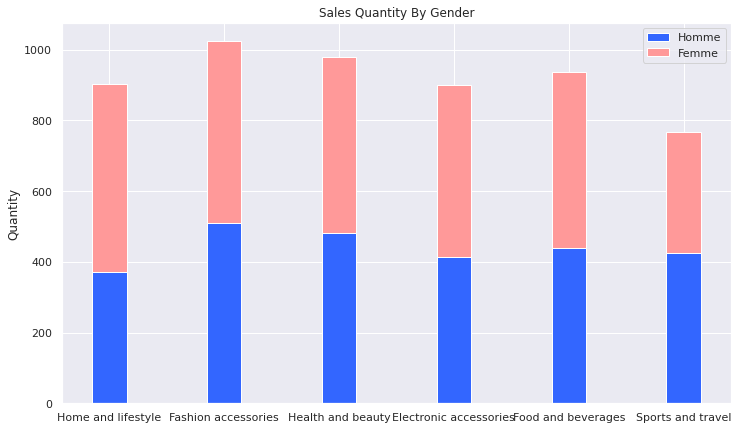

Product line,Rating
Home and lifestyle,1094.0
Fashion accessories,1251.2
Health and beauty,1064.5
Electronic access...,1177.2
Food and beverages,1237.7
Sports and travel,1148.1000000000001


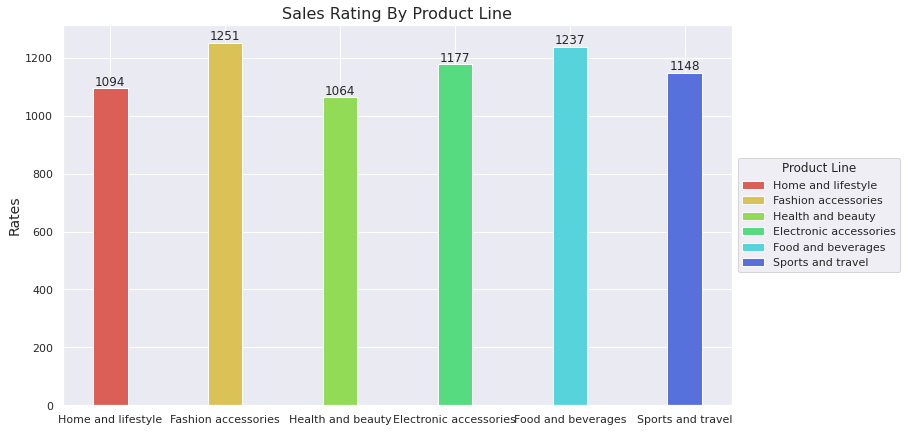

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from matplotlib import pyplot as plt
import seaborn as sns
import pandas
#Creation une session SparkSession
spark = SparkSession \
    .builder \
    .appName("Project Hadoop-Spark") \
    .getOrCreate()
sc = spark.sparkContext
#Améliorer l'affichage PySpark
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
#Récupurer le fichier supermarket_sales.csv a travers adress IP du Container Hadoop
path = "hdfs://172.17.0.2:9000/user/root/supermarket_sales.csv"
#Solution 1:
#Lire le fichier a partir HDFS sous forme Rdd of Strings
fileRdd = sc.textFile(path)
#Les noms des colonnes ce sont doublés
#Récupuré l'objet RDD contient les noms des colonnes
headers = fileRdd.filter(lambda l: "Invoice ID" in l)
#Supprimer le premier element de RDD qui contient les noms des colonnes 
rddNoHeader = fileRdd.subtract(headers)
#split les elements RDD
d=rddNoHeader.map(lambda x: (x.split(',')))
#schema
columns=["Invoice ID","Branch","City","Customer type","Gender","Product line","Unit price","Quantity","Tax 5%","Total","Date","Time","Payment","cogs","gross margin percentage","gross income","Rating"]
#Transformer RDD vers DataFrame
df = spark.createDataFrame(data=d,schema=columns)
#display(df)
#Solution 2:
#utiliser read.csv: Transformer directemenet un fichier csv -> DataFrame sans passer par Rdd
#csv_to_df = spark.read.csv(path,header=True)

sns.set()
plt.clf()
colormap = sns.color_palette("hls", 8)
width = 0.3

#Plot 1 : Distribution Of Gross Income By Product Line
dfplot1=df.groupBy('Product line').agg(sum('gross income').alias('somme'))
display(dfplot1)
label=dfplot1.toPandas()['Product line'].values.tolist()
value=dfplot1.toPandas()['somme'].values.tolist()
fig, ax = plt.subplots(figsize=(12,7))
w,a,b = ax.pie(value, autopct='%1.1f%%', colors=colormap)
plt.title('Distribution Of Gross Income By Product Line')
ax.legend(label, title="Product Line", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
plt.rcParams['figure.figsize']=(12,7)
#Plot 2 : Number Of Sales By Product Line
dfplot2=df.groupBy('Product line').agg(count('Invoice ID').alias('nrbSales'))
display(dfplot2)
x=dfplot2.toPandas()['Product line'].values.tolist()
y=dfplot2.toPandas()['nrbSales'].values.tolist()
plt.bar(x,y,width,color=colormap)
plt.title('Number Of Sales By Product Line',fontsize=16)
plt.ylabel('Number of Sales',fontsize=14)
plt.legend(w, label, title="Product Line", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
for i in range (len(x)):
    plt.text(i,y[i],y[i],ha='center',va='bottom')
plt.show()

#Plot 3 : Sales Quantity By Gender 
dfplot3=df.groupBy('Product line',"Gender").agg(sum('Quantity').alias('Quantity'))
display(dfplot3)
pl=dfplot3.select('Product line').distinct().toPandas()['Product line'].values.tolist()
h=dfplot3.filter(dfplot3.Gender=='Male').toPandas()['Quantity'].values.tolist()
f=dfplot3.filter(dfplot3.Gender=='Female').toPandas()['Quantity'].values.tolist()
fig, ax = plt.subplots()
ax.bar(pl, h, width, label='Homme',color='#3366ff')
ax.bar(pl, f, width,bottom=h,label='Femme',color='#ff9999')
ax.set_ylabel('Quantity')
ax.set_title('Sales Quantity By Gender')
ax.legend()
plt.show()



#Plot 4 : Sales Rating By Product Line
dfplot4=df.groupBy('Product line').agg(sum('Rating').alias('Rating'))
display(dfplot4)
x=dfplot4.toPandas()['Product line'].values.tolist()
y=dfplot4.toPandas()['Rating'].values.tolist()
plt.bar(x,y,width,color=colormap)
plt.title('Sales Rating By Product Line',fontsize=16)
plt.ylabel('Rates',fontsize=14)
plt.legend(w, label, title="Product Line", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
for i in range (len(x)):
    plt.text(i,int(y[i]),int(y[i]),ha='center',va='bottom')
plt.show()